# Lights, Camera, ADA! Barbenheimer in Action

### The Dachshund Detectives - Project Milestone 2

This Notebook contains the initial analyses and data handling pipelines and walks you through the preprocessing steps and descriptive statistics required for this project.
Let's not dwell too long on an introduction and gest started with the data analysis!

Lights, Camera, ADA! It's time to make some sense of the heat surrounding both Barbie and Oppenheimer movies!

## First Steps

In this section the relevant packages and data is loaded that will be used for the initial analysis of the data. Note that since we are currently unsure of all the different types of analysis that will be conducted, the remaining packages will be downloaded in the section of those analyses themselves. The column names are defined to match the ones provided in the description of the data. And some data cleaning is performed in terms of adding a column with just the release year of the movie to the movie_metadata and the character_metadata to cope with the different formats of the release dates already in the data. The new columns with the release year will also be very useful as it allows for annual trends rather than date-based ones.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import json
import statsmodels.api as sm
import nltk
import gdown
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imdb import IMDb

## Imports and Primitive Variables

In [5]:
#Path Variables
DATA_PATH = "./data/MovieSummaries/"

CHARACTER_DATA_PATH = DATA_PATH + "character.metadata.tsv"

MOVIE_DATA_PATH = DATA_PATH + "movie.metadata.tsv"

PLOT_DATA_PATH = DATA_PATH + "plot_summaries.txt"

TVTROPES_CLUSTERS_PATH = DATA_PATH + "tvtropes.cluster.txt"

gdown.download('https://drive.google.com/uc?id=1_RAqSzkuIyg_DZlmiKcFW9enn4o8P2pP', 'IMDB.ratings.tsv', quiet=False)

gdown.download('https://drive.google.com/uc?id=1TjktgE2zlV1eaRVbx0910JXkaSUNlXOS', 'IMDB.titles.tsv', quiet=False)

RATED_MOVIES_PATH = DATA_PATH + 'movies.imdbrating.tsv'

Downloading...
From: https://drive.google.com/uc?id=1_RAqSzkuIyg_DZlmiKcFW9enn4o8P2pP
To: C:\Users\andre\OneDrive\Documents\EPFL Masters\ADA\ADA-Project\IMDB.ratings.tsv
100%|██████████| 23.7M/23.7M [00:05<00:00, 4.02MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1TjktgE2zlV1eaRVbx0910JXkaSUNlXOS
From (redirected): https://drive.google.com/uc?id=1TjktgE2zlV1eaRVbx0910JXkaSUNlXOS&confirm=t&uuid=7f121343-866e-49dc-bf57-03d18a1b4209
To: C:\Users\andre\OneDrive\Documents\EPFL Masters\ADA\ADA-Project\IMDB.titles.tsv
100%|██████████| 1.87G/1.87G [07:14<00:00, 4.31MB/s]


## Data Processing

We decided to supplement our dataset using IMDB ratings which can be found [here](https://developer.imdb.com/non-commercial-datasets/).
In this section, the steps undertaken are straightforward:
 - Load IMDB datasets
 - Load movie and character data 
 - Make the JSON columns easier to format
 - Load plot data 
 - Tokenize strings in plot data to get sentences and words
 - Filter data
 - Merge IMDB datasets with our data
 - Delete IMDB datasets because they are too big\
 In the case of the filtration step, we will provide more comments regarding the decisions made further below in the notebook.

### Loading Movie and Character MetaData

In [6]:
imdbtitles = pd.read_csv('IMDB.ratings.tsv', sep = '\t')

In [7]:
print(imdbtitles.shape)
imdbtitles.head()

(1366349, 3)


,tconst,averageRating,numVotes
0,tt0000001,5.7,2004
1,tt0000002,5.8,269
2,tt0000003,6.5,1903
3,tt0000004,5.5,178
4,tt0000005,6.2,2685


In [9]:
imdbratings = pd.read_csv('IMDB.titles.tsv', sep = '\t')

C:\Users\andre\AppData\Local\Temp\ipykernel_9632\4126362545.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  imdbratings = pd.read_csv('IMDB.titles.tsv', sep = '\t')


In [14]:
print(imdbratings.shape)
imdbratings.head()

(37692942, 8)


,tconst,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


In [11]:
#change column names to match
imdbratings.rename(columns = {imdbratings.keys()[0]:imdbtitles.keys()[0]}, inplace = True)

In [12]:
#merge the datasets
imdbtitles = imdbtitles.merge(imdbratings, on = imdbtitles.keys()[0] , how = 'left')

In [13]:
print(imdbtitles.shape)
imdbtitles.head()

(4885806, 10)


,tconst,averageRating,numVotes,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,5.7,2004,1.0,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,5.7,2004,2.0,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,5.7,2004,3.0,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,5.7,2004,4.0,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5.7,2004,5.0,Карменсита,RU,\N,imdbDisplay,\N,0


In [15]:
#delete the ratings to save memory
del imdbratings

In [16]:
#make movie titles lower case to facilitate merging with the movie metadata
imdbtitles['title'] = imdbtitles['title'].str.lower()
#convert missing fields to NaN
imdbtitles = imdbtitles.replace(to_replace="\\N", value = np.NAN)

In [17]:
imdbtitles.head()

,tconst,averageRating,numVotes,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,5.7,2004,1.0,карменсіта,UA,NaN,imdbDisplay,NaN,0
1,tt0000001,5.7,2004,2.0,carmencita,DE,NaN,NaN,literal title,0
2,tt0000001,5.7,2004,3.0,carmencita - spanyol tánc,HU,NaN,imdbDisplay,NaN,0
3,tt0000001,5.7,2004,4.0,καρμενσίτα,GR,NaN,imdbDisplay,NaN,0
4,tt0000001,5.7,2004,5.0,карменсита,RU,NaN,imdbDisplay,NaN,0


## CMU Movie Corpus processing

In [18]:
#create dataframes
#columns
characters_columns = ["Wikipedia_movie_ID",
                      "Freebase_movie_ID",
                      "Movie_release_date",
                      "Character_name",
                      "Actor_date_of_birth", 
                      "Actor_gender", 
                      "Actor_height", 
                      "Actor_ethnicity", 
                      "Actor_name", 
                      "Actor_age_at_movie_release", 
                      "Freebase_character_actor_map_ID", 
                      "Freebase_character_ID", 
                      "Freebase_actor_ID"]

movies_columns = ["Wikipedia_movie_ID",
                  "Freebase_movie_ID",
                  "title",
                  "Movie_release_date",
                  "Movie_box_office_revenue",
                  "Movie_runtime",
                  "Movie_languages", 
                  "Movie_countries",
                  "Movie_genres"]
#load data
character_data = pd.read_csv(CHARACTER_DATA_PATH, sep = '\t', header = None, names = characters_columns)
movies_data = pd.read_csv(MOVIE_DATA_PATH, sep = '\t', header = None, names = movies_columns)

In [19]:
#print some rows and the size for character data
print(f"Size of character dataframe: {character_data.size}")
print(f"Shape of character dataframe: {character_data.shape}")
character_data.head()

Size of character dataframe: 5858697
Shape of character dataframe: (450669, 13)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [20]:
#print some rows and the size for movie data
print(f"Size of movies dataframe: {movies_data.size}")
print(f"Shape of movies dataframe: {movies_data.shape}")
movies_data.head()

Size of movies dataframe: 735669
Shape of movies dataframe: (81741, 9)


,Wikipedia_movie_ID,Freebase_movie_ID,title,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


### Transfering different columns from a json format to a list format

In [21]:
#convert JSON fields to value only rather than key-value pairs
movies_data["Movie_languages"] = movies_data["Movie_languages"].apply(lambda x : list(set(json.loads(x).values())))
movies_data["Movie_countries"] = movies_data["Movie_countries"].apply(lambda x : list(set(json.loads(x).values())))
movies_data["Movie_genres"] = movies_data["Movie_genres"].apply(lambda x : list(set(json.loads(x).values())))

In [22]:
#print again to see what happened to the data
movies_data.head()

,Wikipedia_movie_ID,Freebase_movie_ID,title,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Science Fiction, Space western, Horror, Actio..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Drama, Biographical film, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Erotic thriller, Thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [23]:
#convert the release date to date time data
movies_data["Movie_year_released"] = pd.to_datetime(movies_data["Movie_release_date"], errors = 'coerce', format = 'mixed').dt.year
character_data["Movie_year_released"] = pd.to_datetime(character_data["Movie_release_date"], errors = 'coerce', format = 'mixed').dt.year

In [24]:
#print again to see what happened to the data
movies_data.head()

,Wikipedia_movie_ID,Freebase_movie_ID,title,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_year_released
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Science Fiction, Space western, Horror, Actio...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Drama, Biographical film, Crime Drama]",2000.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Erotic thriller, Thriller, Psychological thri...",1987.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],1983.0


### Load Plot Data as a dataframe 

In [25]:
#load data
plots_df = pd.read_csv(PLOT_DATA_PATH, sep = '\t', header = None, names = ["Wikipedia_movie_ID", "Plot"])

In [26]:
plots_df.head()

,Wikipedia_movie_ID,Plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


We proceed to convert our plot into analyzable tokens since this would make them analyzable by standard langage processing procedures.

In [27]:
#get sentences and words
plots_df["Sentence_Tokens"] = plots_df['Plot'].apply(lambda x: nltk.tokenize.sent_tokenize(x))


#define function to remove punctuation
def get_word_tokens(sentence):
    words = nltk.tokenize.word_tokenize(sentence)
    words_no_punct = [word for word in words if word.isalpha()]
    return words_no_punct


#plots_df["Word_Tokens"] = plots_df['Plot'].apply(lambda x: get_word_tokens(x))

In [28]:
plots_df.head()

,Wikipedia_movie_ID,Plot,Sentence_Tokens
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a hard-working taxi driver and Lyosh..."
1,31186339,The nation of Panem consists of a wealthy Capi...,[The nation of Panem consists of a wealthy Cap...
2,20663735,Poovalli Induchoodan is sentenced for six yea...,[Poovalli Induchoodan is sentenced for six ye...
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The Lemon Drop Kid , a New York City swindler..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,[Seventh-day Adventist Church pastor Michael C...


## Filtration

In this case, we decided to start by sorting such that the movies dataframe prioritizes the rows with the fewest missing values. We do so because some movies appear in duplicates within the dataset (in terms of name and IDs) so when we drop them we will just keep the instance where we have the most information about them. \
Realistically, this doesn't mean that the extra info is necessarily correct but we will assume it is.

In [29]:
#find NaN count per row
movies_data['NaN_per_row'] = movies_data.isna().sum(axis = 1)
#sort such that fewest NaNs are on top
movies_data = movies_data.sort_values(by = 'NaN_per_row')
#reset indexes
movies_data = movies_data.reset_index(drop = True)
#transform titles to lower case to facilitate merging in the future
movies_data['title'] = movies_data['title'].str.lower()

In [30]:
#drop movies with no freebase nor wikipedia ids and check for duplicates
nb_movies_before_filtering = len(movies_data['Wikipedia_movie_ID'])
movies_data = movies_data.dropna(subset = ['Wikipedia_movie_ID', 'Freebase_movie_ID'])
nb_movies_after_filtering = len(movies_data['Wikipedia_movie_ID'])

print("Number of movies before filtering:", nb_movies_before_filtering)
print("Number of movies after filtering:", nb_movies_after_filtering)

print("Number of unique movies per wikipedia ID:", len(set(movies_data['Wikipedia_movie_ID'])))
print("Number of unique movies per title:", len(set(movies_data['title'])))
print("Number of unique movies per freebase ID:", len(set(movies_data['Freebase_movie_ID'])))

Number of movies before filtering: 81741
Number of movies after filtering: 81741
Number of unique movies per wikipedia ID: 81741
Number of unique movies per title: 75378
Number of unique movies per freebase ID: 81741


We repeat this process with the IMDB dataset to check for duplicates:

In [32]:
print(imdbtitles.shape)
imdbtitles = imdbtitles.dropna(subset = ['title'])
print("Number of unique movie per ImdbID:", len(set(imdbtitles['title'])))

(4536856, 10)
Number of unique movie per ImdbID: 2140466


We notice that there are movies present in duplicates in the CMU movie dataset and obviously duplicates in the IMDB title dataset. The imdb dataset consists of movies and their names in different regions so duplicates are foreseeable. 

In the case of the CMU movie dataset we will drop duplicates using the title column as subset. We would also need another criteria for redundancy assuming there are mistakes in note keeping regarding sequels. For example: movie X and movie X 2. Those are just example but assuming movies with such similar titles exist, it would not be surprising if mistakes were made regarding the title. We would therefore need more specific features that could help dissociate those movies. Release year would be perfect. Runtime would be a close second. Genres is trickier because it is human determined and realistically a movie and its sequel would highly likely share the same genres.  
Previously, we decided to sort the dataset in terms of fewest NaNs. That was so that we could just keep the rows with the most information by keeping first instances when dropping duplicates.

In [33]:
#drop duplicates in movies data on title, release year and runtime
movies_data = movies_data.drop_duplicates(subset = ['title', 'Movie_year_released', 'Movie_runtime'], keep = 'first')

In [35]:
#drop duplicates in imdb dataset to make it lighter, do it on title ID and title
imdbtitles = imdbtitles.drop_duplicates(subset = ['title', 'tconst'])

In [36]:
print("Shape of the movie dataframe:", movies_data.shape)

Shape of the movie dataframe: (81690, 11)


In [37]:
print("Shape of the IMDB dataset:", imdbtitles.shape)

Shape of the IMDB dataset: (2948679, 10)


We proceed to merge into movies data, delete the imdb dataset to make space and we will have to re-delete duplicate rows in the movie dataset since the merge process is bound to create extra rows.

In [38]:
#merge dataset
movies_data = movies_data.merge(imdbtitles, on = 'title', how = 'left')

In [39]:
movies_data.shape

(279693, 20)

In [40]:
#make space
del imdbtitles

In [41]:
#drop new duplicates
movies_data = movies_data.drop_duplicates(subset = ['title', 'Movie_year_released', 'Movie_runtime'], keep = 'first')

In [42]:
movies_data.shape

(81690, 20)

In [43]:
movies_data.head()

,Wikipedia_movie_ID,Freebase_movie_ID,title,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_year_released,NaN_per_row,tconst,averageRating,numVotes,ordering,region,language,types,attributes,isOriginalTitle
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Science Fiction, Space western, Horror, Actio...",2001.0,0,tt0228333,4.9,56867.0,11.0,FR,NaN,NaN,NaN,0
1,1148228,/m/04bfqy,calamity jane,1953-11-04,2500000.0,97.0,[English Language],[United States of America],"[Western, Romance Film, Biography, Musical, Co...",1953.0,0,tt0045591,7.2,10568.0,15.0,RO,NaN,imdbDisplay,NaN,0
7,1039561,/m/040ntm,heavy weights,1995-02-17,17689177.0,100.0,[English Language],[United States of America],"[Slapstick, Comedy-drama, Comedy, Family Film]",1995.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,156644,/m/014kq6,die another day,2002-11-18,431900000.0,133.0,"[English Language, Cantonese, German Language,...","[United Kingdom, United States of America]","[Action, Thriller, Adventure, Glamorized Spy F...",2002.0,0,tt0246460,6.1,226070.0,14.0,SG,en,imdbDisplay,NaN,0
10,6392129,/m/0g3myp,diggstown,1992-08-14,4836637.0,98.0,[English Language],[United States of America],"[Sports, Drama, Crime Comedy, Boxing, Crime Fi...",1992.0,0,tt0104107,6.9,7888.0,18.0,CA,fr,imdbDisplay,NaN,0


Initial data processing has been completed. 
We will just save the new dataframe to a tsv document to make sure that it is always accessible.


In [ ]:
#save document
#movies_data.to_csv(RATED_MOVIES_PATH, sep = '\t',index = False)

# Primary Plots

In this section we have a series of plot in which we get a more general view of the data. This will allow us to check for outliers in the data and give us a general sense of what we have.

Text(0.5, 1.0, 'Number of movies released each year')

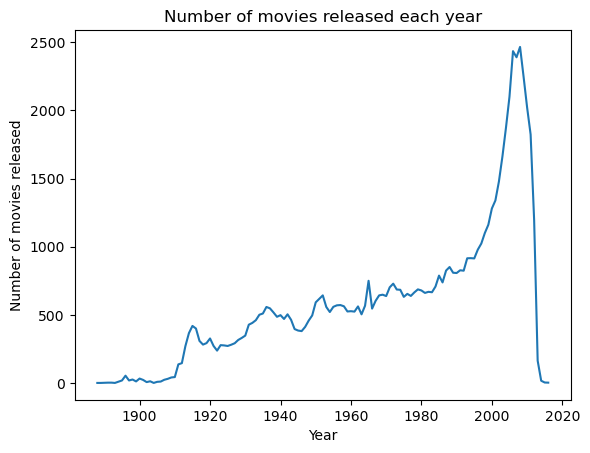

In [44]:
# plot of the number of movies per year

movies_per_year = movies_data.groupby('Movie_year_released').size()

plt.figure()
plt.plot(movies_per_year)
plt.xlabel("Year")
plt.ylabel("Number of movies released")
plt.title("Number of movies released each year")

The plot above looks weird but we double checked. It seems that there was a funny monkey on freebase who decided to add movies such as Kung Fu Panda 3 and Avatar 2 in the dataset before they were even released. The release date wasn't even accurate in some cases. We will omit all movies with release date beyond 2012.

In [45]:
#filtering out movies released after 2012
movies_data_copy = movies_data.copy()

#deal with NaNs to keep those rows as the data might be used a bit more before doing a complete filter
movies_data_copy["Movie_year_released"] = movies_data_copy["Movie_year_released"].fillna(value = 0)
movies_data_copy = movies_data_copy[movies_data_copy["Movie_year_released"]<2013]
#restore Nans
movies_data_copy["Movie_year_released"] = movies_data_copy["Movie_year_released"].replace(0, np.nan)

In [46]:
#188 lines should have been removed
print("Pre filtering shape of movie dataset:",movies_data.shape)

print("Post filtering shape of movie dataset:",movies_data_copy.shape)

Pre filtering shape of movie dataset: (81690, 20)
Post filtering shape of movie dataset: (81502, 20)


We will also print the number of different genres per year and the proportion of each genre per year.

Text(0.5, 1.0, 'Number of different genres released each year')

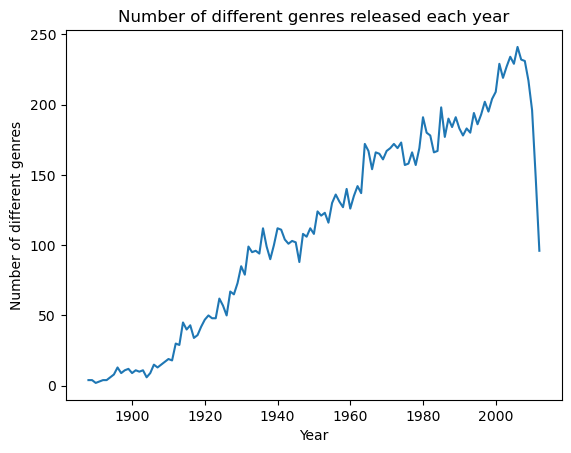

In [47]:
#explode the genre lists into rows
movies_data_copy_exploded = movies_data_copy.explode("Movie_genres")

#get number of different genres
genres_per_year = movies_data_copy_exploded.groupby("Movie_year_released")['Movie_genres'].nunique()

#plot
plt.figure()
plt.plot(genres_per_year)
plt.xlabel("Year")
plt.ylabel("Number of different genres")
plt.title("Number of different genres released each year")

Obviously printing the proportion of each genre per sounds like a bad idea now especially since the number of different genres is too big to be seeable using the naked eye.

In [53]:
#find the frequency of each genre each year
genre_yearly_frequency = movies_data_copy_exploded.groupby(["Movie_year_released","Movie_genres"]).size()
#transform into a stack
stackforplot = genre_yearly_frequency.unstack("Movie_genres").fillna(0)

<Axes: title={'center': 'Stacked Bar Plot of Genres per Year'}, xlabel='Year', ylabel='Proportion of Genres'>

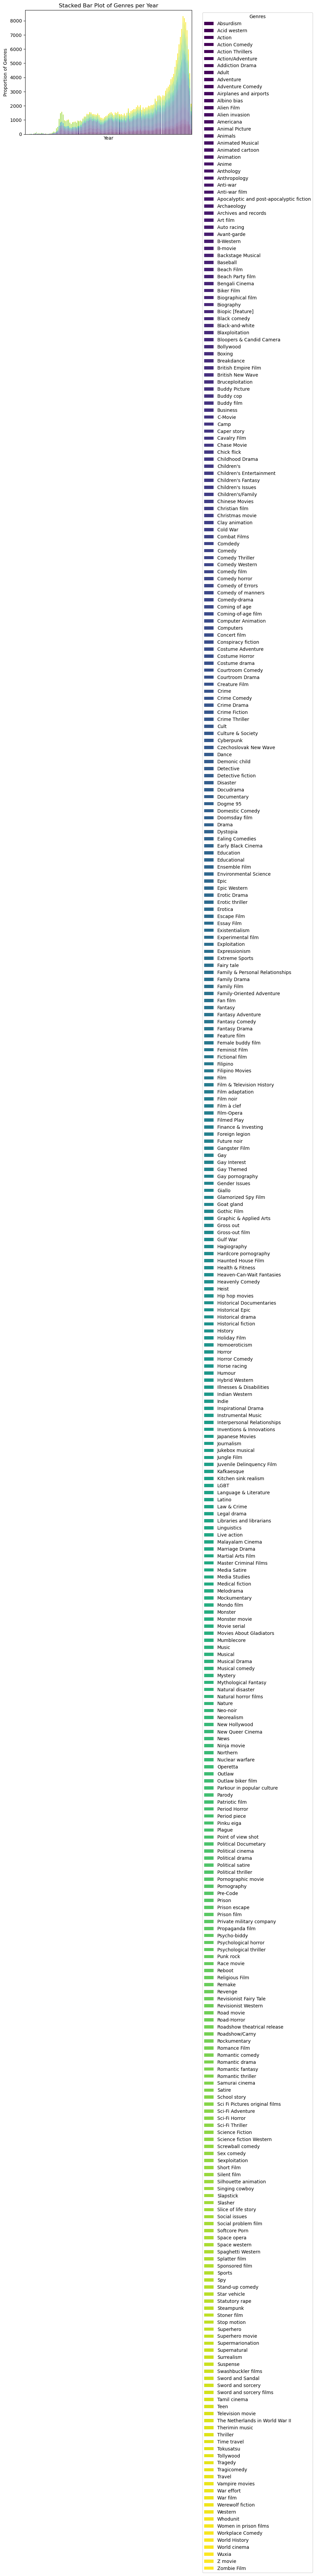

In [56]:
#plot
plot = stackforplot.plot(kind='bar', stacked=True, colormap='viridis')
plot.set_title('Stacked Bar Plot of Genres per Year')
plot.set_xlabel('Year')
plot.set_ylabel('Proportion of Genres')
plot.set_xticks([])
plot.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plot

### Comments: ###
Obviously, the plot does not really show any information. But it does tell us about some of our current limitations and requirements for the future:
- First, there are too many genres and we are in dire need of clustering or at least we will have to filter them ourselves
- Second, it seems that the number of genres grows fast but it is somewhat linear. 

While the presentation of the data in the above plot may seem severely sub-optimal, we decided to show it this way to also represent every possible subgenre. 

--------------------------------

# A bit on grossing and rating#

Now to check the  average grossing and ratings over the years.
In the future we will check for statistical significance among genres.

In [57]:
#getting the yearly average
yearly_average_revenu = movies_data.groupby('Movie_year_released')['Movie_box_office_revenue'].mean()
yearly_average_rating = movies_data.groupby('Movie_year_released')['averageRating'].mean()

Text(0.5, 1.0, 'Average grossing of all movies that year')

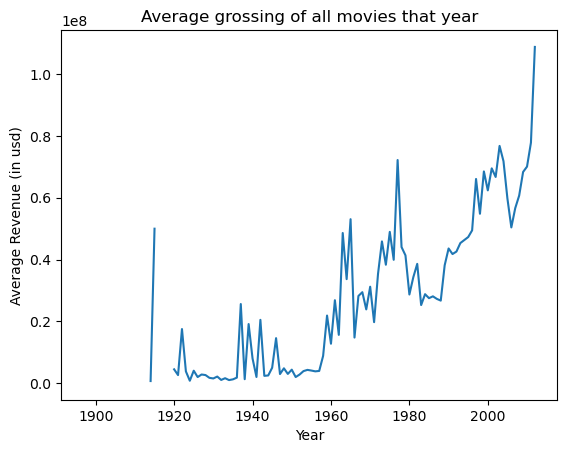

In [63]:
#plot average revenu
plt.figure()
plt.plot(yearly_average_revenu)
plt.xlabel("Year")
plt.ylabel("Average Revenue (in usd)")
plt.title("Average grossing of all movies that year")

Text(0.5, 1.0, 'Average rating of all movies that year')

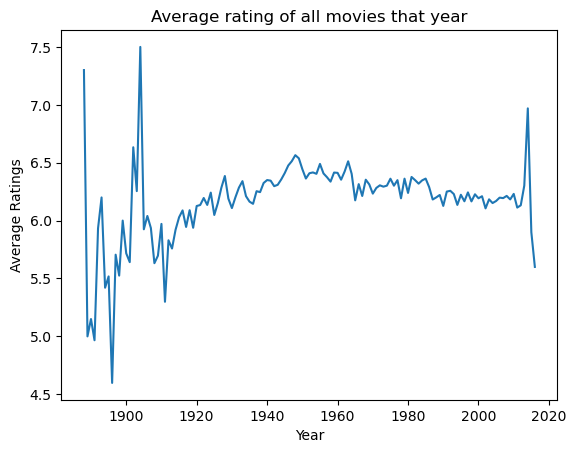

In [64]:
#plot average ratings
plt.figure()
plt.plot(yearly_average_rating)
plt.xlabel("Year")
plt.ylabel("Average Ratings")
plt.title("Average rating of all movies that year")

## Comments: ##
It seems that data before the 1920s is somewhat unreliable on that aspect. 
Funnily enough, we can see some historical events reflecting on the data: world war 2, the vietnam war and the 2008 depression.
Note that the above represents a sort of macro average since all movies are given the same weight disregarding their revenue and the number of raters in their ratings.
We will extend our analysis after clustering to see if any difference appears.

__________________

# A bit more on characters: #

Regarding the characters, we must first filter the data and check for abnormalties. We will do so through plots as it makes it easier to find weird data on more than one axis (ie: todlers who are 10m tall for example)

In [66]:
character_data.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Movie_year_released
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0


## On height: ##

In [67]:
#we will drop NaNs in some columns to get plots
chars_no_nan_height = character_data.dropna(subset = ["Actor_height"])

Text(0.5, 1.0, 'Violin plot of actor heights')

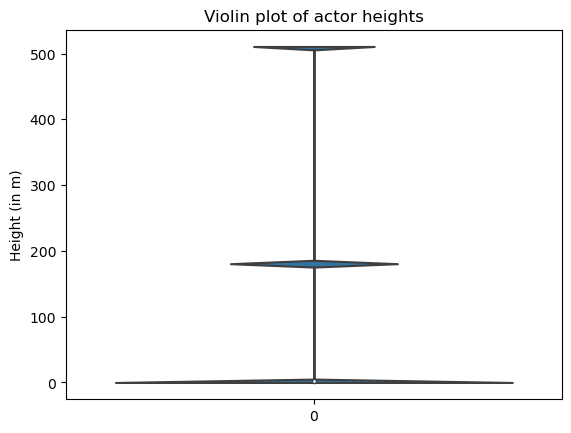

In [70]:
#violin plot of heights
sns.violinplot(chars_no_nan_height["Actor_height"])
plt.ylabel("Height (in m)")
plt.title("Violin plot of actor heights")

We will also draw a boxplot to have an idea of the number of outliers.

Text(0, 0.5, 'Height (in m)')

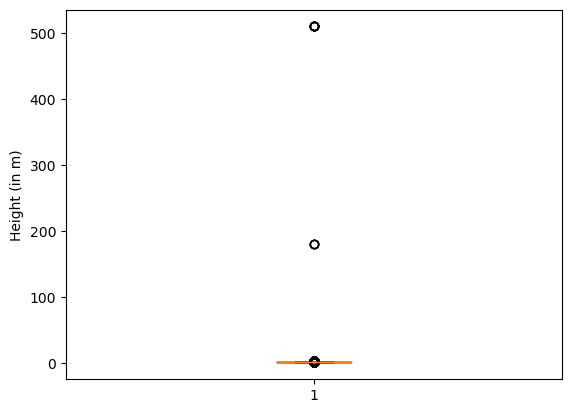

In [71]:
#boxplot of height
plt.boxplot(chars_no_nan_height["Actor_height"])
plt.ylabel("Height (in m)")

It seems there are major outliers. The funny monkeys back at it again and have probably written some centimeter values or feet even.

In [72]:
#filtering out height above 3m
chars_no_nan_height = chars_no_nan_height[chars_no_nan_height["Actor_height"]<3]

Text(0.5, 1.0, 'Violin plot of actor heights (after filtration)')

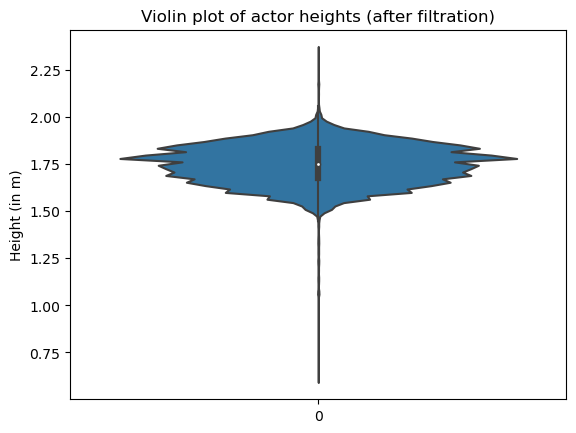

In [75]:
#violin plot of heights
sns.violinplot(chars_no_nan_height["Actor_height"], alpha = 0.3)
plt.ylabel("Height (in m)")
plt.title("Violin plot of actor heights (after filtration)")

Text(0, 0.5, 'Height (in m)')

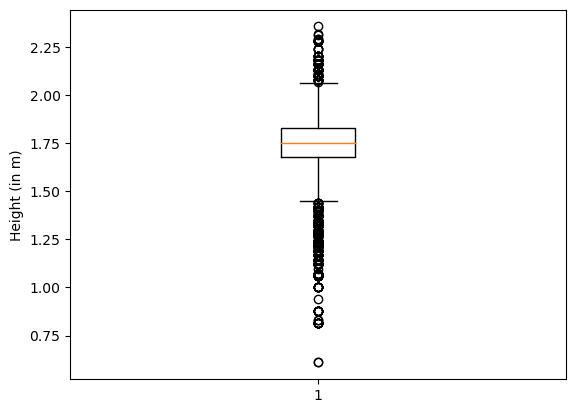

In [76]:
#box plot to show outliers
plt.boxplot(chars_no_nan_height["Actor_height"])
plt.ylabel("Height (in m)")

## Comments: ##
Even after filtration there seems to be outliers. Or are they? 
Realistically, our unidimensional outlook is particularly good at sniffing out obvious outlier (500m tall giant). But it is particularly bad at considering child actors. 
We will therefore plot age vs height to take a better look.

In [87]:
#remove nans in age in previous dataframe
chars_no_nan_age = chars_no_nan_height.dropna(subset = ["Actor_age_at_movie_release"])
#removing duplicate actors
chars_no_nan_dups = chars_no_nan_age.drop_duplicates(subset = ["Actor_name","Actor_height"])

Text(0.5, 1.0, 'Actor ages and their heights')

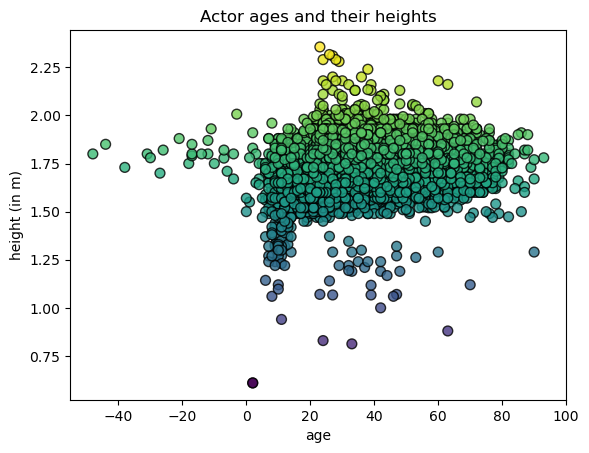

In [89]:
#plot height vs age
plt.figure()
plt.scatter(chars_no_nan_dups["Actor_age_at_movie_release"], chars_no_nan_dups["Actor_height"], s=50, cmap='viridis', c=chars_no_nan_dups["Actor_height"], edgecolors='k', alpha=0.8)
plt.xlabel("age")
plt.ylabel("height (in m)")
plt.title("Actor ages and their heights")

## Comments: ##
We already see an obvious problem: some people have negative ages. 
We are also not mentioning giant 1 year olds. 
We proceed to filter them.

In [97]:
#remove everyone aged below 0 and kids with heights above 1.6m
char_data_filtered = chars_no_nan_age[chars_no_nan_age["Actor_age_at_movie_release"]>=0]
filter_array1 = char_data_filtered["Actor_age_at_movie_release"]<10
filter_array2 = char_data_filtered["Actor_height"]>=1.6
char_data_filtered = char_data_filtered[~( filter_array1 & filter_array2 )]
#drop duplicates for plot only
nochardups = char_data_filtered.drop_duplicates(subset = ["Actor_name","Actor_height"])

Text(0.5, 1.0, 'Actor ages and their height after filtering')

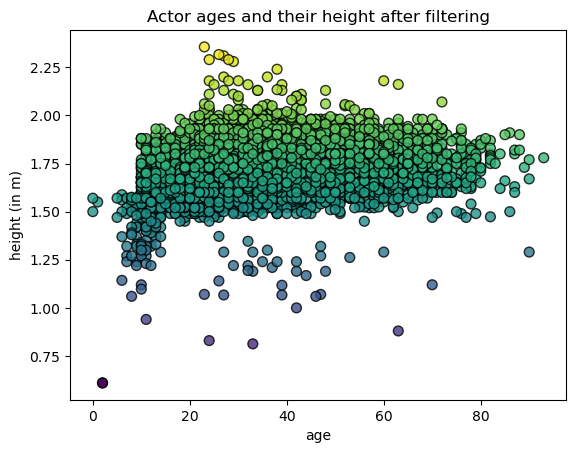

In [98]:
#plot height vs age to check filtration
plt.figure()
plt.scatter(nochardups["Actor_age_at_movie_release"], nochardups["Actor_height"], s=50, cmap='viridis', c=nochardups["Actor_height"], edgecolors='k', alpha=0.8)
plt.xlabel("age")
plt.ylabel("height (in m)")
plt.title("Actor ages and their height after filtering")

## Comments: ##
The filtering itself is a bit crude but it should be good enough. For our current purposes.\ 
Obviously we will have to refilter the data post clustering.But at least we know that we have relatively clean data now.

# On the movie clusters and clustering itself: #

In [100]:
# Load the data
name_clusters = pd.read_csv('./data/MovieSummaries/name.clusters.txt', sep='\t', header=None, names=['Character_name', 'Freebase_movie_ID'])
tvtropes_clusters = pd.read_csv(TVTROPES_CLUSTERS_PATH, sep='\t', header=None, names=['Character_archetype', 'Character_data'])

# maybe not the most efficient way but it works
tvtropes_clusters = pd.merge(tvtropes_clusters['Character_archetype'], pd.json_normalize(tvtropes_clusters['Character_data'].apply(json.loads)), left_index=True, right_index=True)
tvtropes_clusters.columns = ['Character_archetype', 'Character_name', 'Movie_name', 'Freebase_character_actor_map_ID', 'Actor_name']

## Merging datasets

In this step we associate the characters and their archetype if provided.

In [101]:
# Group archetypes by Freebase_character_actor_map_ID and set them as list
tvtropes_clusters_grouped = tvtropes_clusters.groupby('Freebase_character_actor_map_ID')['Character_archetype'].apply(list)
# Add archetypes to characters data
characters_full = pd.merge(char_data_filtered, tvtropes_clusters_grouped, how='left', on='Freebase_character_actor_map_ID')
characters_full.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Movie_year_released,Character_archetype
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,NaN


## More data cleaning

In the following data cleaning steps missing data and duplicate data is handled. 

In [102]:
# Remove data where the character name and actor are missing
characters_dropna = characters_full.dropna(subset=['Freebase_character_ID','Freebase_actor_ID'], how='all')
characters_dropna.shape

(139051, 15)

In [103]:
# Remove duplicate characters (previously checked that none of them had different archetypes)
characters_clean = characters_dropna.drop_duplicates(subset=['Freebase_movie_ID','Freebase_character_ID','Freebase_actor_ID'])
characters_clean.shape

(139045, 15)

## Genre clustering

The Barbie and Oppenheimer movies are part of different genres. Were wondering if we can observe the genres and subgenres that stand out in both movies and compare them to how well those subgenres have done in other movies? 
Furthermore, we want to find out how relevant the combination of genres and subgenres are for the success of a movie. And what would happen if Barbie and Oppenheimer integrated a new subgenre in their respective movies? 

To answer these questions we start by getting more familiar with the genres in the data and then create a matrix of the genres attributed to each movie. The idea for this movie genre matrix is to have the movies ach correspond to one row and the genres each correspond to a column. If a genre is in a movie then a "1" is set in that matrix entry, else it is a "0". We're planning on using this matrix for further analysis.

In [104]:
### Getting all the genres

# Convert lists to strings and then join to get one big string
all_genres_string = ','.join(movies_data['Movie_genres'].apply(lambda x: ','.join(x))) # Chose , in lambda so that the genres of one movie is seperated from genres of next movie with a ,

# Now we can split the string around ',' to get a list of all the genres with recurring genres (not unique yet)
# Split the joined string to get a list of all genres and use set to remove non-unique strings
unique_genres_set = set(all_genres_string.split(','))

# Remove any empty strings
unique_genres_set = {item for item in unique_genres_set if item}

# Turn the set back into a list (if necessary)
unique_genres_list = list(unique_genres_set)

#print(unique_genres_list)

In [108]:
movies_data['Movie_genres']

0         [Science Fiction, Space western, Horror, Actio...
1         [Western, Romance Film, Biography, Musical, Co...
7            [Slapstick, Comedy-drama, Comedy, Family Film]
8         [Action, Thriller, Adventure, Glamorized Spy F...
10        [Sports, Drama, Crime Comedy, Boxing, Crime Fi...
                                ...                        
279686                                              [Drama]
279687                                            [Tragedy]
279688                            [Action, Science Fiction]
279690                                     [Western, Drama]
279692                                              [Drama]
Name: Movie_genres, Length: 81690, dtype: object

In [112]:
### Matrix of genres in movies
# This section creates a matrix where each row corresponds to a movie and each column to a genre. If a genre is in a movie then a 1 is set in that (i,j) matrix entry. Else it is a 0. 
# Create a MultiLabelBinarizer instance
mlb = MultiLabelBinarizer()

# Transform the 'Movie_genres' column into a binary matrix with movies in rows and genres in columns.
binary_matrix = pd.DataFrame(mlb.fit_transform(movies_data['Movie_genres']), columns=mlb.classes_, index=movies_data['title'])

# Print the matrix entries
#print(binary_matrix.loc['Ghosts of Mars'])
#print(binary_matrix['Action'])

# Turn the dataframe into a numpy array
matrix_of_genres = binary_matrix.values
print(matrix_of_genres.shape)

(81690, 363)


### Perform PCA to prepare data for clustering

To cluster the movie genres we have already constructed a matrix of the genres (see step before). In this step we prepare the data for clustering by reducing the dimensionality by means of performing PCA.

Total explained variance: 0.9432482647520294
Number of compenents= 38


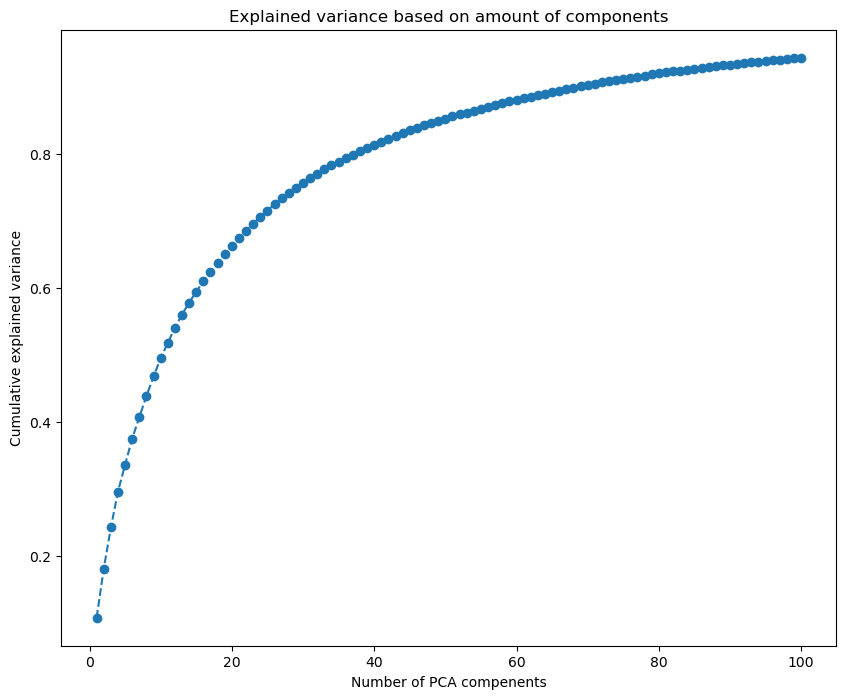

In [115]:
# Dim reduction for visualisation
pca = PCA(100)
 
#Transform the data
matrix_of_genres_pca = pca.fit_transform(matrix_of_genres)
print("Total explained variance:",pca.explained_variance_ratio_.sum())
plt.figure(figsize = (10,8))
plt.plot(range(1,101),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.xlabel('Number of PCA compenents')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance based on amount of components')

# We want to choose a PCA that keeps about 80% of the variance
number_of_components_to_keep = (np.where(pca.explained_variance_ratio_.cumsum()>0.8))[0][0]+1
print('Number of compenents=', number_of_components_to_keep)

pca = PCA(42)
matrix_of_genres_pca = pca.fit_transform(matrix_of_genres)
#scores_pca = pca.transform(matrix_of_genres)

### K-means clustering


This section is dedicated to k-means clustering. 


First of all we performed K-means but a movie being a certain genre is categorical data and we should therefore also look at k-modes. We notice that our Silhouette score doesn't have a maximum so further analysis will be needed to determine if a larger number of clusters is better, if the use of k-means here is a poor choice and holds relevance or if it is simpler to cluster the movies "by hand" with regards to genre. An attempt was made at using DBSCAN but so far to no avail.

In [116]:
### We will run Kmeans for many different number of clusters and plot the Within-Cluster Sum of Square (WCSS) to determine which number of clusters is best
wcss = []
silhouette_scores = []
number_of_clusters = 30
for i in range(1,number_of_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init="auto")
    
    # Silhouette
    #if i>=2:
    #    kmeans_labels = kmeans.fit_predict(matrix_of_genres_pca)
    #    silhouette_scores.append(silhouette_score(matrix_of_genres_pca,kmeans_labels))
    
    # WCSS
    kmeans = kmeans.fit(matrix_of_genres_pca)
    kmeans_labels=kmeans.labels_
    if i>=2: 
        silhouette_scores.append(silhouette_score(matrix_of_genres_pca,kmeans_labels)) ## NOT WORKING
    wcss.append(kmeans.inertia_)
    print(i)

### In the next parts we will visualize the results

### Gotta check silhouette measure to see what number of clusters is good. Maybe change init, maybe do soft kmeans etc.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In the next parts we will visualize the results

Text(0.5, 1.0, 'K-means with PCA clustering WCSS')

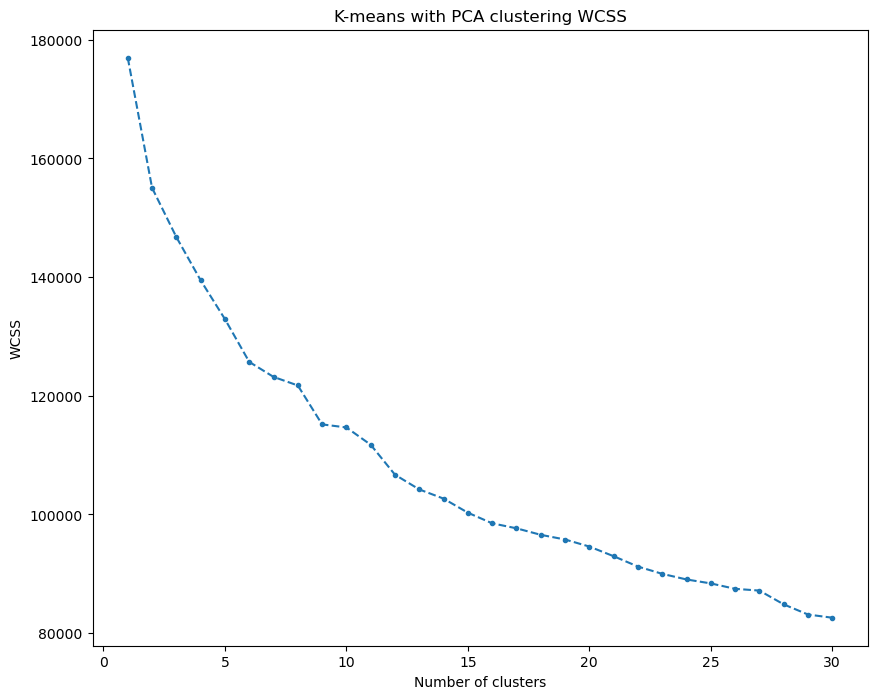

In [117]:
### Plotting the WCSS

plt.figure(figsize = (10,8))
plt.plot(range(1,number_of_clusters+1),wcss,marker='o',markersize=3,linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA clustering WCSS')

To determine the number of clusters we look for the "elbow" in the graph and here we estimate that it comes at 14 clusters.

In [118]:
kmeans = KMeans(n_clusters=14, init='k-means++', random_state=42, n_init="auto").fit(matrix_of_genres_pca)

Text(0.5, 1.0, 'K-means with PCA clustering Silhouette score')

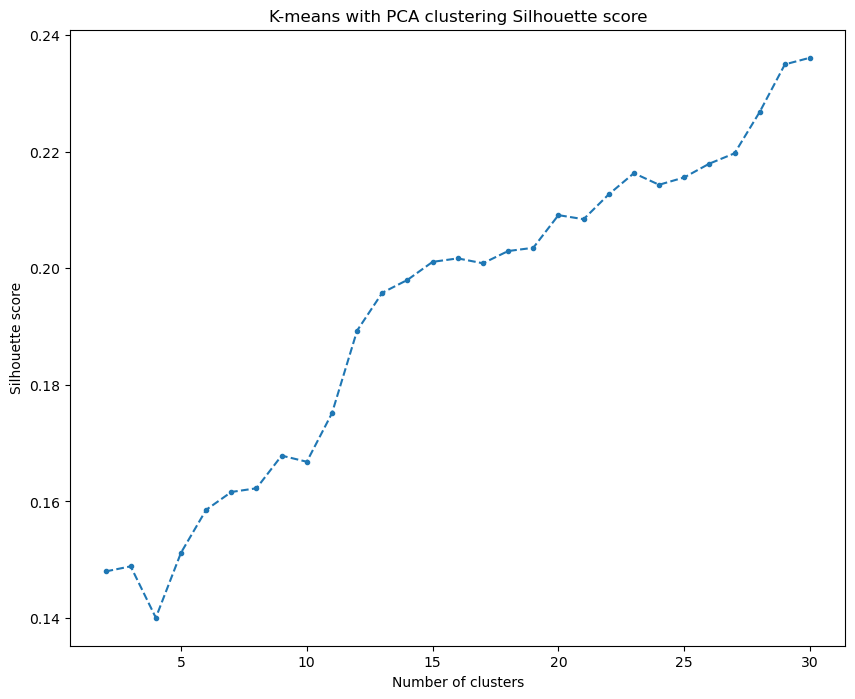

In [119]:
#plot
plt.figure(figsize = (10,8))
plt.plot(range(2,number_of_clusters+1),silhouette_scores,marker='o',markersize=3,linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('K-means with PCA clustering Silhouette score')

Based on silhouette score we need to run kmeans with even more clusters and find out where the max is, 
the elbow is probably somewhere else in the WCSS.

## Trying IMDb

While getting familiar with the data we have noticed that we are missing some information that we wouldlike in the analysis of our data. One particular thing is that for many movies the provided plot summary is quite short and we would like to include more infromation, especially as we're planning on doing sentiment analysis as a part of the nuance analysis to see if  Barbie's positive nuances vs Oppenheimer's darker/negative nuances are can be discerned.

Therefore we decided to use IMDb to enrich our data. Concerning the length of the movie plot summaries we decided to compare the lengths of the summaries on IMDb to the lengths of the summaries we already have and keepthe longer one. As IMDb limits the amount for requests one can make per day, we have decided to each accumulate some data and then merge our datasets to have a completed dataset in a feasible time frame. We devided the movies as following:

Thomas: 1-8444

Marin: 8445-16884

Emi: 16885-25324

Sophie: 25325-33764

Andrew: 33765-42204



In [6]:
# Create an instance of the IMDb class
ia = IMDb()

In [ ]:
# Get IMDb summaries for first 10 movies
for index in range(0,10):
    try:
        # If release year is available, add it to the search for more accurate results
        movie_search = ia.search_movie(movies_data.loc[index]['Movie_name'] + " " + str(int(movies_full.loc[index]['Movie_year_released'])))
    except ValueError:
        # If not, only include the movie name
        movie_search = ia.search_movie(movies_data.loc[index]['Movie_name'])
    print(movies_data.loc[index]['Movie_name'])
    
    # If matches are found, get the first result (we assume it is the most relevant)
    if len(movie_search) > 0:
        movie = ia.get_movie(movie_search[0].movieID)
        print(movie.get('localized title'))
        
        # Get synopsis if available, it contains more information
        try:
            summary = movie.data['synopsis'][0]
        except KeyError:
            summary = movie.data['plot'][0]
        else:
            summary = ""
        
        print(summary)
        # Keep the longest summary
        if len(summary) > len(movies_full.loc[index]['Plot_summary']):
            movies_full.loc[index]['Plot_summary'] = summary
            print('Used IMDb')
        else:
            print('Used movie dataset')

from imdb import IMDb# Creating IMDb dataset

In [ ]:
from imdb import IMDb

# Create an instance of the IMDb class
ia = IMDb()

In [ ]:
dtype_mapping = {'imdbID': 'Int64', 'release_year': 'Int64', 'votes': 'Int64', 'runtime': 'Int64'}

imdb_movies = pd.read_csv('data/IMDb/IMDb_movies.csv', dtype=dtype_mapping)
imdb_movies.head(3)

In [ ]:
def get_movie_info(movie_name, movie_year):
    movie_data = pd.Series()
    
    # search for a movie, assuming the first search result is the desired movie
    try:
        movie_id = ia.search_movie(movie_name + ' ' + movie_year)[0].movieID
    except IndexError:
        return movie_data
    movie = ia.get_movie(movie_id)
    
    # get information
    try:
        movie_data['imdbID'] = movie['imdbID']
    except KeyError:
        pass
    
    try:
        movie_data['movie_name'] = movie['title']
    except KeyError:
        pass
    
    try:
        movie_data['release_year'] = movie['year']
    except KeyError:
        pass
    
    try:
        movie_data['genres'] = movie['genres']
    except KeyError:
        pass
    
    try:
        movie_data['rating'] = movie['rating']
    except KeyError:
        pass
    
    try:
        movie_data['votes'] = movie['votes']
    except KeyError:
        pass
    
    try:
        movie_data['cast'] = [cast['name'] for cast in movie['cast']]
    except KeyError:
        pass
    
    try:
        movie_data['castID'] = [cast.personID for cast in movie['cast']]
    except KeyError:
        pass
    
    try:
        movie_data['directors'] = [director['name'] for director in movie['director']]
    except KeyError:
        pass
    
    try:
        movie_data['directorsID'] = [director.personID for director in movie['director']]
    except KeyError:
        pass
    
    try:
        movie_data['runtime'] = movie['runtimes'][0]
    except KeyError:
        pass
    
    try:
        movie_data['plot_summary'] = movie['synopsis'][0]
    except KeyError:
        try:
            movie_data['plot_summary'] = movie['plot'][0]
        except KeyError:
            pass
    
    return movie_data

## Filling the dataset:

Thomas: 1-8444\
Marin: 8445-16884\
Emi: 16885-25324\
Sophie: 25325-33764\
Andrew: 33765-42204

In [ ]:
'''
number_of_loops = 1000

for i in range(len(imdb_movies),len(imdb_movies) + number_of_loops):
    print(i)
    try:
        imdb_movies.loc[len(imdb_movies)] = get_movie_info(movies.loc[i]['Movie_name'], str(movies.loc[i]['Movie_year_released']))
    except ValueError:
        imdb_movies.loc[len(imdb_movies)] = get_movie_info(movies.loc[i]['Movie_name'], '')
'''

In [ ]:
#imdb_movies.to_csv('data/IMDb/IMDb_movies.csv', index=False)

The cut is a bit too sudden but for now we are sure regarding these values